In [26]:
from fastai.vision import *
from PIL import Image
import torchvision
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F 

from fastai.layers import FlattenedLoss

from collections import defaultdict, OrderedDict

from os import mkdir, environ # just for my use to access environment variables, not required

In [2]:
## edit these for your system
ROOT = Path( "{}/data/streetstyle".format( environ["FASHION_DIR"] ) ) # optional
IMAGES_PATH = ROOT/"streetstyle27k_cropped"
CSV = ROOT/"ss27k_labels.csv"
MODEL_SAVE_DIR = ROOT/"models"
MODEL_SAVE_NAME = "ss27k_base" # will be the first part of all saved files

# these can all be changed either here on in the call to build_databunch
bs = 120
im_size = 224
val_pct = 0.1
test_pct = 0.1

# random seed
seed = 42

# set this if you have a rtx card, can sometimes be faster and also allows you to have larger batch sizes
use_fp16 = False

In [3]:
df = pd.read_csv( CSV ).sample( frac=1, random_state=seed )
df.head()

,image,label
4047,9ddcffd1f26e8029f739a4533c509652_5633154888954...,clothing_pattern_solid major_color_blue wearin...
24772,c3d3eb00c32cfb20a9dba781c1a3478d_5850821475942...,clothing_pattern_plaid major_color_multicolore...
18190,8db86044eadc3c402e8a8528cbefe9ae_6566812053337...,clothing_pattern_solid major_color_black weari...
16221,7264bc219aa44909f75cc61059b6b359_6044493198652...,clothing_pattern_graphics major_color_white we...
13060,aaeaebb9d93603f1d51ec0a21b016aee_5157556788998...,clothing_pattern_solid major_color_white weari...


In [4]:
def build_databunch( val_p=val_pct, test_p=test_pct, batch=bs, size=im_size ):
    val_len = int( len( df ) * val_p )
    test_len = int( len( df ) * test_p )
    val_p = val_len / ( len( df ) - test_len )
    
    train_val_df = df[test_len:]
    test_df = df[:test_len]
    
    data = ( ImageList.from_df( df=train_val_df, path=IMAGES_PATH )
                .split_by_rand_pct( valid_pct=val_p, seed=seed )
                .label_from_df( label_delim=' ' ) )
    test_data = ( ImageList.from_df( df=test_df, path=IMAGES_PATH )
                .split_none()
                .label_from_df( label_delim=' ' ) )
    
    data.test = test_data.train
    
    ds_tfms = get_transforms()
    data = ( data.transform( ds_tfms, size=im_size )
             .databunch( bs=batch ).normalize( imagenet_stats ) )
        
    return data

In [5]:
# taken from the previous cohort

class FocalLoss_v2(nn.Module):
    """
    Taken from https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
    """
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss_v2, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, reduction = 'mean'):
        
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        
        pt = torch.exp(-BCE_loss)
        
        alpha_t = (self.alpha - 1) * targets + 1
        
        loss = alpha_t * (1-pt)**self.gamma * BCE_loss

        if reduction =='none' or reduction is None:
            return loss
        elif reduction =='mean':
            return loss.mean()
        elif reduction=='sum':
            return loss.sum()
        else:
            raise NotImplementedError

def focal_flat_loss(*args, **kwargs):
    return FlattenedLoss(FocalLoss_v2, *args, is_2d = False, **kwargs)

In [6]:
data = build_databunch()

In [7]:
arch = models.resnet34
threshold = 0.15
acc = partial( accuracy_thresh, thresh=threshold )
f_score = partial( fbeta, thresh=threshold )
learn = cnn_learner( data, arch, metrics=[acc, f_score] )
learn.loss_func = focal_flat_loss( gamma = 2, alpha = 0.25 )

if use_fp16:
    learn = learn.to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


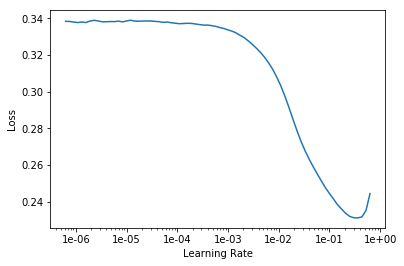

In [8]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [9]:
learn.fit_one_cycle( 4, max_lr=slice(1e-2) )
learn.save( MODEL_SAVE_DIR/"{}_resnet34_focalloss_step1".format( MODEL_SAVE_NAME ) )

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.053517,0.030863,0.624302,0.717767,01:08
1,0.033063,0.028263,0.653530,0.737400,00:57
2,0.029895,0.026453,0.653318,0.740502,00:57
3,0.028713,0.025935,0.665989,0.747486,00:57


/home/lewis/.pyenvs/fellowshipai_brands/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FocalLoss_v2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


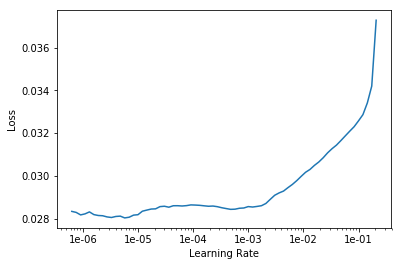

In [10]:
learn.load( MODEL_SAVE_DIR/"{}_resnet34_focalloss_step1".format( MODEL_SAVE_NAME ) )
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.load( MODEL_SAVE_DIR/"{}_resnet34_focalloss_step1".format( MODEL_SAVE_NAME ) )
learn.unfreeze()
learn.fit_one_cycle( 6, max_lr=slice(5e-5, 5e-4) )
learn.save( MODEL_SAVE_DIR/"{}_resnet34_focalloss_step2".format( MODEL_SAVE_NAME ) )

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.027168,0.024126,0.685304,0.759701,01:17
1,0.025937,0.023211,0.703216,0.769777,01:17
2,0.024845,0.022356,0.717255,0.780198,01:17
3,0.023677,0.021528,0.747633,0.797330,01:17
4,0.022490,0.021092,0.755350,0.802167,01:17
5,0.022041,0.021021,0.755001,0.802166,01:17


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


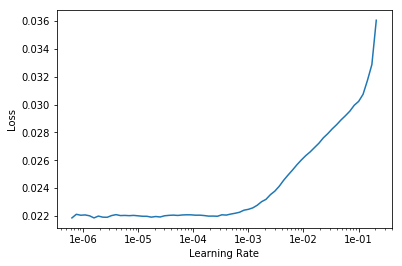

In [12]:
learn.load( MODEL_SAVE_DIR/"{}_resnet34_focalloss_step2".format( MODEL_SAVE_NAME ) )
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.load( MODEL_SAVE_DIR/"{}_resnet34_focalloss_step2".format( MODEL_SAVE_NAME ) )
learn.unfreeze()
learn.fit_one_cycle( 5, max_lr=slice(1e-7, 1e-6) )
learn.save( MODEL_SAVE_DIR/"{}_resnet34_focalloss_step3".format( MODEL_SAVE_NAME ) )

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.021917,0.021020,0.754420,0.801662,01:17
1,0.021882,0.021012,0.753996,0.801747,01:17
2,0.022061,0.021022,0.754611,0.801759,01:17
3,0.021909,0.021000,0.753831,0.801410,01:17
4,0.021993,0.021009,0.755624,0.802485,01:17


In [14]:
learn.load( MODEL_SAVE_DIR/"{}_resnet34_focalloss_step3".format( MODEL_SAVE_NAME ) )

if use_fp16:
    learn = learn.to_fp32()

In [15]:
cats = [ "major_color", "sleeve_length", "clothing_pattern", "neckline_shape", 
        "clothing_category", "multiple_layers", "wearing_necktie", 
        "collar_presence", "wearing_scarf", "wearing_jacket", 
        "wearing_hat", "wearing_glasses" ]

idx_to_cat = [0] * len( data.classes )
for i, cat in enumerate( cats ):
    for n, label in enumerate( data.classes ):
        if cat in label:
            idx_to_cat[n] = i

In [16]:
probs, ys = learn.get_preds( ds_type=DatasetType.Test )
probs = probs.sigmoid()

In [54]:
len(data.classes)

58

In [17]:
def split_to_label_pred( preds ):
    cat_preds = defaultdict( list )
    for n, pred in enumerate( preds ):
        cat = cats[idx_to_cat[n]]
        try:
            cat_preds[cat].append( float( pred ) )
        except ValueError:
            cat_preds[cat].append( pred )
    
    cat_preds = { k: np.array( v ) for k, v in cat_preds.items() }
    return cat_preds

In [67]:
thres = 0
ignore_na = False # doesn't count the example at all when calculating averages for each category

if ignore_na:
    subcats = split_to_label_pred( data.classes )
    no_label_idx = dict()

    for cat, subs in subcats.items():
        for n, subcat in enumerate( subs ):
            if "no_label" in subcat:
                no_label_idx[cat] = n

pred_eg = split_to_label_pred( ys[0] )
performance = { k: [ 0.0, 0 ] for k in cats }
performance_per_label = { k: OrderedDict( [ ( v, [ 0.0, 0 ] ) for v in data.classes if k in v ] ) for k in cats }
performance_per_label_idx = { k: list( v.items() ) for k, v in performance_per_label.items() }

for prob, y in zip( probs, ys ):
    prob, y = split_to_label_pred( prob ), split_to_label_pred( y )
    for cat in cats:
        prob_cat, y_cat = prob[cat], y[cat]
        
        if thres:
            prob_cat -= [ prob if prob <= thres else 0 for prob in prob_cat ]
        
        argmax = np.argmax( prob_cat )
        y_argmax = np.argmax( y_cat )
        label = performance_per_label_idx[cat][y_argmax][0]
        
        if argmax == y_argmax and prob_cat[argmax] > 0.0:
            if ignore_na and ( no_label_idx[cat] == argmax ):
                continue
                
            performance_per_label[cat][label][0] += 1.0
            performance[cat][0] += 1.0
        
        performance_per_label[cat][label][1] += 1.0
        performance[cat][1] += 1.0

for k, v in performance.items():
    performance[k] = v[0]/v[1]
    
    for k2, v2 in performance_per_label[k].items():
        performance_per_label[k][k2] = v2[0]/v2[1]

In [66]:
performance

{'major_color': 0.6154761904761905,
 'sleeve_length': 0.7309523809523809,
 'clothing_pattern': 0.7555555555555555,
 'neckline_shape': 0.7396825396825397,
 'clothing_category': 0.5892857142857143,
 'multiple_layers': 0.8257936507936507,
 'wearing_necktie': 0.9785714285714285,
 'collar_presence': 0.8357142857142857,
 'wearing_scarf': 0.9468253968253968,
 'wearing_jacket': 0.8575396825396825,
 'wearing_hat': 0.921031746031746,
 'wearing_glasses': 0.9742063492063492}

In [52]:
performance_per_label

{'major_color': OrderedDict([('major_color_black', 0.8945686900958466),
              ('major_color_blue', 0.6169354838709677),
              ('major_color_brown', 0.05128205128205128),
              ('major_color_cyan', 0.0),
              ('major_color_gray', 0.264),
              ('major_color_green', 0.42592592592592593),
              ('major_color_multicolored', 0.3418803418803419),
              ('major_color_no_label', 0.42226487523992323),
              ('major_color_orange', 0.0),
              ('major_color_pink', 0.4647887323943662),
              ('major_color_purple', 0.0),
              ('major_color_red', 0.7525773195876289),
              ('major_color_white', 0.8426150121065376),
              ('major_color_yellow', 0.62)]),
 'sleeve_length': OrderedDict([('sleeve_length_long_sleeve',
               0.8590342679127726),
              ('sleeve_length_no_label', 0.11864406779661017),
              ('sleeve_length_no_sleeve', 0.8313609467455622),
              ('sleeve_l